# **Name Calling by Samsung PRISM** 
*   This code is implemented by the Team **Congruent.**
###**The Team Members are :**
            Swaraj Gupta (swaraj.gupta217@gmail.com)
            Shiv Jaiswal (shivjaiswal2000@gmail.com)
            Mayank Goyal (goyalmayank522@gmail.com)









In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Importing Required Libraries/Dependencies**

In [245]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.io
import sklearn

import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf
from keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D,MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
from keras.optimizers import Adam

#**Path to the train and test wav**

* The dataset used for training and testing purpose is taken from google drive.
* The train_wav folder consists of 1000 wav files for training.
* The test_wav folder consists of 260 wav files for testing.
* The dataset consists of 20 different name variations. 
* Length of each audio file is <= 1sec and stored in wav format.

In [3]:
path_to_train_wav='/content/drive/MyDrive/prism_dataset/train_wav'
path_to_test_wav='/content/drive/MyDrive/prism_dataset/test_wav'

#**Defining Class Labels & other Variables**

* The dataset is trained on 20 different name variations.
* List (labels) is used for labeling the training and testing data point.
* List are initialized which will hold the training and testing set later.

In [4]:
labels = 'abhishek anmol anurag deewanshu himanshu kishan mayank narender neeraj prince ritvik sayan shiv shreyas shubham siddharth sourav swaraj utkarsh vikrant'.split()

# empty list to hold training and testing set later.
train_data = []
train_label = []
test_data = []
test_label = []

#**Data Preprocessing**
* Scaling the mel-scaled spectogram between 0-1

In [5]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

##**Extracting melspectogram feature corresponding to the training and testing wav files**

* Each wav file is passed to the librosa.load function which return two parameter y and sr.
* First one **Audio time-series** , y[t] correspond to amplitude of waveform at sample t. It is one-dimensional (numpy.ndarray) of floating-point values.
* Second one is the **sample rate** which is explicity given a value of 16000.
* The audio file is truncated if it's length is more than 1 second.
* Also, the audio file is padded with 0 if it's length is less than 1 second.
* After that, y is passed to the librosa.feature.spectogram function to compute a **mel-scaled spectrogram**.
* Scaling the mel-scaled spectrogram between 0-1.
* Finally, data array and label array are created for training and testing data.

In [6]:
# Creating data and label for training
for filename in os.listdir(path_to_train_wav):
    wavefile = path_to_train_wav  + '/' + str(filename)
    y, sr = librosa.load(wavefile, mono=True,duration=1,sr=16000)
    N = 16000-len(y)
    y=np.pad(y, (0, N), 'constant')
    melspec = librosa.feature.melspectrogram(y=y, sr=sr)
    img = scale_minmax(melspec, 0, 255).astype(np.uint8) 
    image_array = np.expand_dims(img, axis=-1)
    train_data.append(image_array)
    for temp in range(len(labels)):
        if labels[temp]== filename[:-7]:  
            train_label.append(temp)
            break

In [7]:
# Creating data and label for testing
for filename in os.listdir(path_to_test_wav):
    wavefile = path_to_test_wav  + '/' + str(filename)
    y, sr = librosa.load(wavefile, mono=True,duration=1,sr=16000)
    N = 16000-len(y)
    y=np.pad(y, (0, N), 'constant')
    melspec = librosa.feature.melspectrogram(y=y, sr=sr)
    img = scale_minmax(melspec, 0, 255).astype(np.uint8)
    image_array = np.expand_dims(img, axis=-1)
    test_data.append(image_array)
    for temp in range(len(labels)):
        if labels[temp]== filename[:-7]:  
            test_label.append(temp)
            break

##**Creating (x_train, y_train) for training  and (x_test, y_test) for testing dataset**

* The train_data, train_label, test_data & test_label lists are converted to numpy arrays.
* Then x_train, y_train, x_test & y_test are created.

In [586]:
# Converting training images to training array
train_data1 = np.asarray(train_data)
train_label1 = np.asarray(train_label)

# Converting testing images to testing array
test_data1 = np.asarray(test_data)
test_label1 = np.asarray(test_label)

In [587]:
# Creating x_train and y_train
x_train=train_data1
y_train=train_label1

# Creating x_test and y_test
x_test=test_data1
y_test=test_label1

# # printing the shape of x_train and y_train
# print(x_train.shape)
# print(y_train.shape)

# # printing the shape of x_test and y_test
# print(x_test.shape)
# print(y_test.shape)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255
 
input_shape = x_train.shape[1:]
print(x_train.shape)

(1000, 128, 32, 1)


#**Function for creating positive-negative training testing pairs**

* Positive Pair is created by picking a data point from one class and make pair with another data point from the same class (A1,A2,1).
* Negative Pair is created by picking a data point from one class and make pair with another data point from the different class (A1,B1,0).
* Value 1 and 0 repersent positive and negative pair respectively.
* Number of pair created is doubled the number of data point present as one data point is used for making a positive pair and a negative pair.

In [588]:
def create_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []
    # calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
  # loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append(1)
    # grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *n ot* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append(0)
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

#**Euclidean Distance function and Constrastive loss function**

In [589]:
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))
 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
 
def contrastive_loss(y_true, y_pred):
    y_true=tf.dtypes.cast(y_true, tf.float64)
    y_pred=tf.dtypes.cast(y_pred, tf.float64)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1-y_true) * margin_square)

#**Accuracy function**


In [590]:
def compute_accuracy(y_true, y_pred):
    # Compute classification accuracy with a fixed threshold on distances.
    
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
 
 
def accuracy(y_true, y_pred):
    # Compute classification accuracy with a fixed threshold on distances.
    
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

#**Creating the Positive and Negative image pairs**

* Passing x_train and y_train for getting training pair and corresponding label.
* Passing x_test and y_test for getting testing pair and corresponding label.
* These pair is fitted to the siamese network for training and testing purpose.

In [591]:
tr_pairs, tr_y = create_pairs(x_train, y_train)
te_pairs, te_y = create_pairs(x_test, y_test)

#**Siamese CNN model**
* The network consists of 2 Conv2D layer followed alternatively by two AveragePooling2D layer.
* The activation function in both Conv2D and AveragePooling2D layer is given (tanh).
* The number of neurons in first and second Conv2D is 4 and 16 respectively and the kernel size given is (5,5).
* A flatten layer is taken followed by the last dense layer with activation (tanh)






## **Creating basic CNN network**

In [623]:
def create_base_net(input_shape):
   
  input = Input(shape = input_shape)
  x = Conv2D(4, (5,5), activation = 'tanh')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Dropout(0.85)(x)
  x = Conv2D(8, (5,5), activation = 'tanh')(x)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Dropout(0.35)(x)
  x = Flatten()(x)
  x = Dense(20, activation = 'tanh',kernel_regularizer=regularizers.l2(0.001))(x)
  x = Dense(16, activation = 'sigmoid')(x)
  model = Model(input, x)
  model.summary()
  return model
  # require structure definition after finalizing it

In [624]:
base_network = create_base_net(input_shape)

Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        [(None, 128, 32, 1)]      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 124, 28, 4)        104       
_________________________________________________________________
average_pooling2d_72 (Averag (None, 62, 14, 4)         0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 62, 14, 4)         0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 58, 10, 8)         808       
_________________________________________________________________
average_pooling2d_73 (Averag (None, 29, 5, 8)          0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 29, 5, 8)          0  

##**Defining Siamese Network**



In [594]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
 
processed_a = base_network(input_a)
processed_b = base_network(input_b)
 
distance = Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b], distance)

##**Compiling & Training the Model**
* Loss: Contrastive loss
* Optimizer: Adam
* Batch size: 32
* epochs: 150

In [595]:
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=32,
          epochs=150,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))  # callbacks=[EarlyStopping(monitor='loss', patience=4, min_delta=0.0001)],



Epoch 1/150
63/63 [==============================] - 2s 13ms/step - loss: 0.3730 - accuracy: 0.5030 - val_loss: 0.3470 - val_accuracy: 0.5000
Epoch 2/150
63/63 [==============================] - 1s 9ms/step - loss: 0.2923 - accuracy: 0.5367 - val_loss: 0.3553 - val_accuracy: 0.5000
Epoch 3/150
63/63 [==============================] - 1s 9ms/step - loss: 0.2966 - accuracy: 0.5010 - val_loss: 0.3247 - val_accuracy: 0.5055
Epoch 4/150
63/63 [==============================] - 1s 9ms/step - loss: 0.2881 - accuracy: 0.5273 - val_loss: 0.3048 - val_accuracy: 0.5239
Epoch 5/150
63/63 [==============================] - 1s 9ms/step - loss: 0.2784 - accuracy: 0.5456 - val_loss: 0.2660 - val_accuracy: 0.5938
Epoch 6/150
63/63 [==============================] - 1s 9ms/step - loss: 0.2681 - accuracy: 0.5828 - val_loss: 0.2500 - val_accuracy: 0.6324
Epoch 7/150
63/63 [==============================] - 1s 9ms/step - loss: 0.2560 - accuracy: 0.6136 - val_loss: 0.2416 - val_accuracy: 0.6397
Epoch 8/150


##**Plot of accuracy vs epochs**

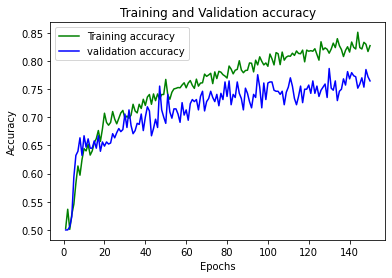

In [596]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,151)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##**Plot of loss vs epochs**

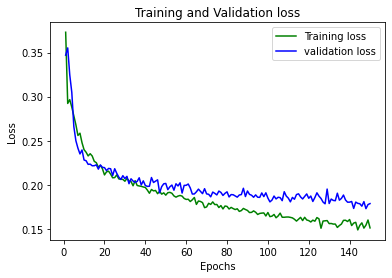

In [599]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,151)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##**Saving the Model**

In [600]:
model.save('/content/drive/MyDrive/prism_model/model_congruent',save_format='H5')
model = keras.models.load_model('/content/drive/MyDrive/prism_model/model_congruent', compile=False)
model.summary()

INFO:tensorflow:Assets written to: /content/drive/MyDrive/prism_model/model_congruent/assets
Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_93 (InputLayer)           [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
input_94 (InputLayer)           [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
model_60 (Functional)           (None, 16)           24468       input_93[0][0]                   
                                                                 input_94[0][0]                   
_________________________________________________________________________________________________

In [601]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred_test = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred_test)
 
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on validation set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 89.50%
* Accuracy on validation set: 76.54%


Storing prediction on train data

In [602]:
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])

True label for train data

In [603]:
tr_y[:50]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0])

Predicted label on train data

In [604]:
y_pred = y_pred.ravel() < 0.5
y_pred[:50]

array([ True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True,  True,  True, False,  True, False,  True, False,  True,
        True,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False, False, False,  True,
       False,  True, False,  True, False])

Storing prediction on test data

In [605]:
y_pred_test = model.predict([te_pairs[:, 0], te_pairs[:, 1]])

True label for test data

In [606]:
te_y[:10]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

Predicted label on test data

In [607]:
y_pred_test[:10]

array([[8.0740047e-01],
       [6.6455615e-01],
       [3.1622776e-04],
       [6.6632408e-01],
       [6.7497247e-01],
       [7.3326957e-01],
       [5.5339134e-01],
       [4.4182035e-01],
       [6.9493878e-01],
       [7.6498985e-01]], dtype=float32)

In [608]:
y_pred_test = y_pred_test.ravel() < 0.5
y_pred_test[:10]

array([False, False,  True, False, False, False, False,  True, False,
       False])

# **Computing Performance Metrics**

###**ROC-AUC Score**

In [609]:
from sklearn.metrics import roc_auc_score
print("roc_auc_score value for training: ",  sklearn.metrics.roc_auc_score(tr_y, y_pred))
print("roc_auc_score value for validation: " , sklearn.metrics.roc_auc_score(te_y, y_pred_test))

roc_auc_score value for training:  0.895
roc_auc_score value for validation:  0.7653846153846154


###**Matthews Corrcoef**

In [610]:
from sklearn.metrics import matthews_corrcoef
print("matthews_corrcoef on taining data : " , sklearn.metrics.matthews_corrcoef(tr_y, y_pred))
print("matthews_corrcoef on validation data : " , sklearn.metrics.matthews_corrcoef(te_y, y_pred_test))

matthews_corrcoef on taining data :  0.7924142016040873
matthews_corrcoef on validation data :  0.5310206610205516


###**F1-Score**

In [611]:
from sklearn.metrics import f1_score
print("f1_score on training data : " , f1_score(tr_y, y_pred))
print("f1_score on validation data : " , f1_score(te_y, y_pred_test))

f1_score on training data :  0.8989412897016362
f1_score on validation data :  0.7617187500000001


# **Conclusion**

Finally, the model is trained on the Siamese CNN network. There may be some model overfitting due to the smaller dataset (which can easily be removed by using some augmentation techniques) but inspite of that the results are really very nice and impressive.